```{index} single: Pyomo; block
```
```{index} single: Pyomo; kernel library
```
```{index} single: conic optimization; exponential cones
```
```{index} single: solver; Mosek
```
```{index} single: application; portfolio
```
```{index} single: application; investment
```
# Extra material: Luenberger's Investment Wheel

In [1]:
# install Pyomo and solvers
import sys
import os

SOLVER_CONIC = "mosek_direct"

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
    SOLVER_CONIC = "ipopt"

## Problem statement

David Luenberger presents an "investment wheel" in Chapter 18 of his book *Investment Science*. The wheel is divided into sectors, each marked with a number. An investor places wagers on one or more sectors before spinning the wheel.  When the wheel stops, the investor receives a payout equal to the wager times the number appearing next to the marker. The wagers on all other sectors are lost. The game is repeated indefinitely.

![](investment-wheel.png)

Given an initial wealth $W_0$, what is your investing strategy for repeated plays of the game?

* Is there an investing strategy that almost surely grows? 
* What is the mean return for each spin of the wheel?

In [2]:
# specify the investment wheel
wheel = {
    "A": {"p": 1/2, "b": 3},
    "B": {"p": 1/3, "b": 2},
    "C": {"p": 1/6, "b": 6},
}

## Simulation

The following cell provides an interactive simulation of the investment wheel. The weighting parameters $w_A$, $w_B$, and $w_C$ represent the fraction of the investor's current stake that is wagered on sectors $A$, $B$, and $C$, respectively. Experiment with the simulation to find weights that produce an acceptable compromise between long term return and risk.

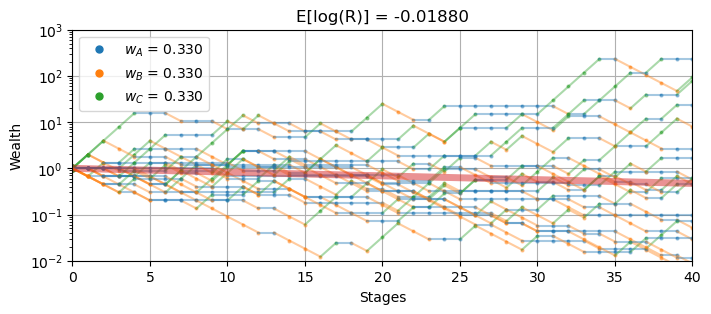

interactive(children=(FloatSlider(value=0.333, description='wA', max=1.0, step=0.01), FloatSlider(value=0.333,…

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import bisect

import ipywidgets as widgets

def wheel_sim(w, T,  N):
    # set of wheel sectors
    S = list(wheel.keys())
    
    # odds, probability, and quantiles
    b = {s: wheel[s]["b"] for s in S}
    p = {s: wheel[s]["p"] for s in S}
    q = np.cumsum(list(p.values()))
    
    # gross return for each sector
    R = {s: 1 + w[s]*b[s] - sum(w.values()) for s in S}
    
    # set up plot and colors
    _, ax = plt.subplots(1, 1, figsize=(8, 3))
    colors = {s: ax.semilogy(0, 1, '.', ms=10)[0].get_color() for s in S}
    
    # repeat the simulation N times
    for _ in range(N):
        wealth = 1.0
        for k in range(T):
            
            # spin the wheel
            spin = np.random.uniform()
            s = S[bisect.bisect_left(q, spin)]
            wealth_next = wealth * R[s]
            
            # add to plot
            ax.semilogy([k, k+1], [wealth, wealth_next], c=colors[s], alpha=0.4)
            ax.semilogy(k+1, wealth_next, '.', ms=4, c=colors[s], alpha=0.4)
            wealth = wealth_next

    # compute expected log return
    ElogR = sum(p[s] * np.log(R[s]) for s in S)
    ax.plot(np.exp(ElogR*np.linspace(0, T, T+1)), lw=5, alpha=0.5)
    ax.set_title(f"E[log(R)] = {ElogR:0.5f}")
    ax.legend([f"$w_{s}$ = {w[s]:0.3f}" for s in S])
    ax.set_xlim(0, T)
    ax.set_ylim(0.01, 1000.0)
    ax.set_ylabel("Wealth")
    ax.set_xlabel("Stages")
    ax.grid(True)
    return ax
    
wheel_sim({"A":0.33, "B":0.33, "C":0.33}, 40, 20)
    
@widgets.interact_manual(
    wA = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.333),
    wB = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.333),
    wC = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.333),
)
def wheel_interact1(wA, wB, wC):
    w = {"A": wA, "B": wB, "C": wC}
    wheel_sim(w, 40, 20)

## Modeling

The investment wheel is an example of a game with $n=3$ outcomes. Each outcome $n$ offers payout $b_n$ that occurs with probability $p_n$ as given in the following table.

| Outcome | Probability $p_n$ | Odds $b_n$ |
| :--: | :--: | :--: |
| A | 1/2 | 3 |
| B | 1/3 | 2 |
| C | 1/6 | 6 |

If a $w_n$ of current wealth is wagered on each outcome $n$, then the gross returns $R_n$ are given in the following table.

| Outcome | Probability $p_n$ | Gross Returns $R_n$ |
| :--: | :--: | :--: |
| A | 1/2 | 1 + 2$w_A$ - $w_B$ - $w_C$ |
| B | 1/3 | 1 - $w_A$ + $w_B$ - $w_C$ |
| C | 1/6 | 1 - $w_A$ - $w_B$ + 5$w_C$ |

Following the same analysis used for the Kelly criterion, the optimization problem is to maximize expected log return 

$$
\begin{align}
\max_{w \geq 0}\quad & \sum_{n\in N} p_n \log(R_n) \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
\end{align}
$$

The objective function can be reformulated exponential cones to a conic optimization problem.

$$
\begin{align}
\max_{w\geq 0}\quad & \sum_{n\in N} p_n q_n \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
& (R_n, 1, q_n) \in K_{exp} & \forall n \in N \\
\end{align}
$$

The solution of this optimization problem is shown below.

Expected Log Return =  0.06758

Sector A:  p = 0.500   b = 3.00   w = 0.423
Sector B:  p = 0.333   b = 2.00   w = 0.218
Sector C:  p = 0.167   b = 6.00   w = 0.128


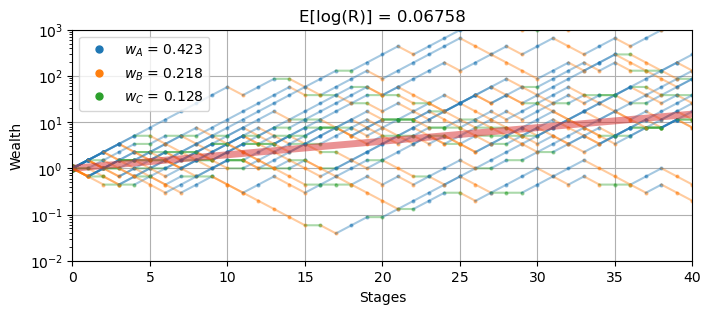

In [4]:
import pyomo.kernel as pmo

def wheel_model(wheel):

    m = pmo.block()
    
    m.S = wheel.keys()

    # decision variables
    m.w = pmo.variable_dict({s: pmo.variable(lb=0) for s in m.S})
    m.q = pmo.variable_dict({s: pmo.variable() for s in m.S})
    
    # objective
    m.ElogR = pmo.objective(sum(wheel[s]["p"]*m.q[s] for s in m.S), sense=pmo.maximize)
    
    # expression for returns
    m.R = pmo.expression_dict({s: pmo.expression(1 + wheel[s]["b"]*m.w[s] - sum(m.w[s] for s in m.S)) for s in m.S})
    
    # constraints
    m.sum_w = pmo.constraint(sum(m.w[s] for s in m.S) <= 1)
    m.conic = pmo.block_dict({s: pmo.conic.primal_exponential.as_domain(m.R[s], 1, m.q[s]) for s in m.S})

    # solve
    pmo.SolverFactory(SOLVER_CONIC).solve(m)

    return m
        
m = wheel_model(wheel)

print(f"Expected Log Return = {m.ElogR(): 0.5f}\n")
for s in m.S:
    print(f"Sector {s}:  p = {wheel[s]['p']:0.3f}   b = {wheel[s]['b']:0.2f}   w = {m.w[s]():0.3f}")
    
w = {s: m.w[s]() for s in m.S}
wheel_sim(w, 40, 20);

## Adding risk aversion

The Kelly criterion has favorable properties for the long term investor, but suffers from a significant chance of "drawdown" where the investor's wealth drops below the initial value, sometimes without recovering for a long period of time.  For this reason, investors normally augment the Kelly criterion with some sort of strategy for risk aversion. 

He we follow the analysis of Busseti, Ryu, and Boyd (2016) for risk-constrained Kelly gambling. Consider a constraint

$$\mathbb{E}[R^{-\lambda}] \leq 1$$

where $\lambda$ is a risk aversion parameter. For the case of $N$ discrete outcomes

$$\sum_{n\in N} p_n R_n^{-\lambda} \leq 1$$

The case $\lambda=0$ is always satisfied and imposes no further restrictions on an optimization problem. This is this case of no risk-aversion. If $\lambda > 0$ then outcomes with gross returns less than one are penalized. As $\lambda \rightarrow \infty$ no solutions are admissible with a gross return less than one. In that case a feasible solution $w_n = 0$ for all $n\in N$ always exists, and there may other non-trivial solutions as well.

Replacing each term with an exponential

$$\sum_{n\in N} e^{\log(p_1) - \lambda\log(R_1)} \leq 1$$

Introducing $u_n \geq e^{\log(p_n) - \lambda q_n}$ using the $q_n$ defined above, we get

$$
\begin{align}
\sum_{n\in N} u_n & \leq 1 \\
(u_n, 1, \log(p_n) - \lambda q_n) & \in K_{exp} & \forall n\in N \\
\end{align}
$$

The risk-constrained investment wheel is now


$$
\begin{align}
\max_{w\geq 0}\quad & \sum_{n\in N} p_n q_n \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
&\sum_{n\in N} u_n  \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
& (R_n, 1, q_n) \in K_{exp} & \forall n \in N \\
& (u_n, 1, \log(p_n) - \lambda q_n) \in K_{exp} & \forall n\in N \\
\end{align}
$$

The following cell creates a risk-constrained model of the investment wheel.

Risk-aversion lambda = 2.000
Expected Log Gross Return =  0.06025

Sector A:  p = 0.5000   b = 3.00   w = 0.36329
Sector B:  p = 0.3333   b = 2.00   w = 0.26547
Sector C:  p = 0.1667   b = 6.00   w = 0.12575


<Axes: title={'center': 'E[log(R)] = 0.06025'}, xlabel='Stages', ylabel='Wealth'>

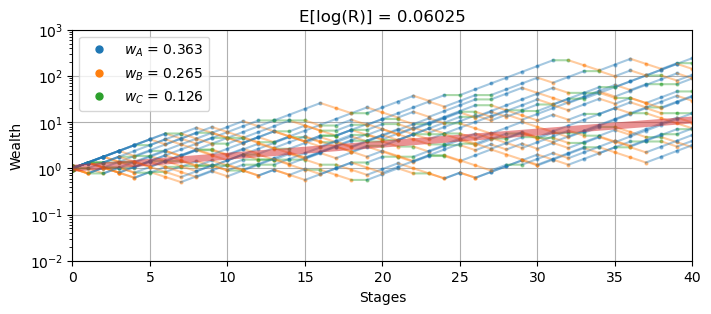

In [5]:
import pyomo.kernel as pmo

def wheel_rc_model(wheel, lambd=0):

    m = pmo.block()
    
    m.S = wheel.keys()

    # decision variables
    m.w = pmo.variable_dict({s: pmo.variable(lb=0) for s in m.S})
    m.q = pmo.variable_dict({s: pmo.variable() for s in m.S})
    
    # objective
    m.ElogR = pmo.objective(sum(wheel[s]["p"]*m.q[s] for s in m.S), sense=pmo.maximize)
    
    # expression for returns
    m.R = pmo.expression_dict({s: pmo.expression(1 + wheel[s]["b"]*m.w[s] - sum(m.w[s] for s in m.S)) for s in m.S})
    
    # constraints
    m.sum_w = pmo.constraint(sum(m.w[s] for s in m.S) <= 1)
    m.conic = pmo.block_dict({s: pmo.conic.primal_exponential.as_domain(m.R[s], 1, m.q[s]) for s in m.S})
    
    # risk constraints
    m.u = pmo.variable_dict({s: pmo.variable() for s in m.S})
    m.sum_u = pmo.constraint(sum(m.u[s] for s in m.S) <= 1)
    m.risk =  pmo.block_dict(
        {s: pmo.conic.primal_exponential.as_domain(m.u[s], 1, np.log(wheel[s]["p"]) - lambd*m.q[s]) for s in m.S}
    )

    # solve
    pmo.SolverFactory(SOLVER_CONIC).solve(m)

    return m
    
lambd = 2
m = wheel_rc_model(wheel, lambd)

print(f"Risk-aversion lambda = {lambd:0.3f}")
print(f"Expected Log Gross Return = {m.ElogR(): 0.5f}\n")
for s in m.S:
    print(f"Sector {s}:  p = {wheel[s]['p']:0.4f}   b = {wheel[s]['b']:0.2f}   w = {m.w[s]():0.5f}")
    
w = {s: m.w[s]() for s in m.S}
wheel_sim(w, 40, 20)

In [6]:
@widgets.interact_manual(
    lambd = widgets.FloatSlider(min=0.0, max=20.0, step=0.1, value=2),
)
def wheel_interact2(lambd):
    m = wheel_rc_model(wheel, lambd)
    w = {s: m.w[s]() for s in m.S}
    wheel_sim(w, 40, 20)


interactive(children=(FloatSlider(value=2.0, description='lambd', max=20.0), Button(description='Run Interact'…

## How does risk aversion change the solution?

The following cell demonstrates the effect of increasing the risk aversion parameter $\lambda$.

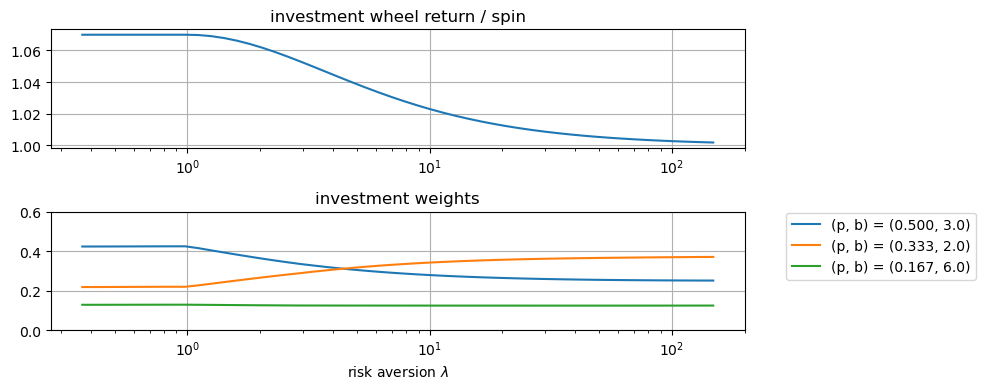

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(10, 4))

v = np.linspace(-1, 5)
lambd = np.exp(v)
results = [wheel_rc_model(wheel, _) for _ in lambd]

ax[0].semilogx(lambd, [np.exp(m.ElogR()) for m in results])
ax[0].set_title('investment wheel return / spin')
ax[0].grid(True)

ax[1].semilogx(lambd, [[m.w[s]() for s in wheel.keys()] for m in results])
ax[1].set_title('investment weights')
ax[1].set_xlabel('risk aversion $\lambda$')
ax[1].legend([f"(p, b) = ({wheel[s]['p']:0.3f}, {wheel[s]['b']:0.1f})" for s in m.S],
            bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, 0.6)

fig.tight_layout()

## Exercises

1. Is there a deterministic investment strategy for the investment wheel?. That is, is there investment strategy that provides a fixed return regardless of the outcome of the spin? Set up and solve a model to find that strategy.

2. Find the variance in the outcome of the wheel, and plot the variance as a function of the risk aversion parameter $\lambda$. What is the relationship of variance and $\lambda$ in the limit as $\lambda \rightarrow 0$? See the paper by Busseti, E., Ryu, E. K., & Boyd, S. (2016) for ideas on how to perform this analysis.

## Bibliographic Notes

The Kelly Criterion has been included in many tutorial introductions to finance and probability, and the subject of popular accounts.

> Poundstone, W. (2010). Fortune's formula: The untold story of the scientific betting system that beat the casinos and Wall Street. Hill and Wang. https://www.onlinecasinoground.nl/wp-content/uploads/2020/10/Fortunes-Formula-boek-van-William-Poundstone-oa-Kelly-Criterion.pdf

> Thorp, E. O. (2017). A man for all markets: From Las Vegas to wall street, how i beat the dealer and the market. Random House.

> Thorp, E. O. (2008). The Kelly criterion in blackjack sports betting, and the stock market. In Handbook of asset and liability management (pp. 385-428). North-Holland. https://www.palmislandtraders.com/econ136/thorpe_kelly_crit.pdf

> MacLean, L. C., Thorp, E. O., & Ziemba, W. T. (2010). Good and bad properties of the Kelly criterion. Risk, 20(2), 1.  https://www.stat.berkeley.edu/~aldous/157/Papers/Good_Bad_Kelly.pdf

> MacLean, L. C., Thorp, E. O., & Ziemba, W. T. (2011). The Kelly capital growth investment criterion: Theory and practice (Vol. 3). world scientific. https://www.worldscientific.com/worldscibooks/10.1142/7598#t=aboutBook

>  https://en.wikipedia.org/wiki/Kelly_criterion

Luenberger's investment wheel is 

> Luenberger, D. (2009). Investment science: International edition. OUP Catalogue.  https://global.oup.com/ushe/product/investment-science-9780199740086


The utility of conic optimization to solve problems involving log growth is more recent. Here are some representative papers.

> Cajas, D. (2021). Kelly Portfolio Optimization: A Disciplined Convex Programming Framework. Available at SSRN 3833617. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3833617

> Busseti, E., Ryu, E. K., & Boyd, S. (2016). Risk-constrained Kelly gambling. The Journal of Investing, 25(3), 118-134. https://arxiv.org/pdf/1603.06183.pdf


> Fu, A., Narasimhan, B., & Boyd, S. (2017). CVXR: An R package for disciplined convex optimization. arXiv preprint arXiv:1711.07582. https://arxiv.org/abs/1711.07582

> Sun, Q., & Boyd, S. (2018). Distributional robust Kelly gambling. arXiv preprint arXiv: 1812.10371. https://web.stanford.edu/~boyd/papers/pdf/robust_kelly.pdf

The recent work by CH Hsieh extends these concepts in important ways for real-world implementation.

> Hsieh, C. H. (2022). On Solving Robust Log-Optimal Portfolio: A Supporting Hyperplane Approximation Approach. arXiv preprint arXiv:2202.03858. https://arxiv.org/pdf/2202.03858
